In [46]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./index.md
./module-p8.ipynb
./.ipynb_checkpoints/module-p8-checkpoint.ipynb
./data/train_filled.csv
./data/test.csv
./data/train.csv
./data/transactions.csv
./data/oil.csv
./data/holidays_events.csv
./data/sample_submission.csv
./data/stores.csv


In [48]:
#!pip install "gluonts[mxnet,pro]"

## EDA

In [49]:
from datetime import datetime

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_test.date.min()
df_test.date.max()
min = datetime.strptime(df_test.date.min(), '%Y-%M-%d')
max = datetime.strptime(df_test.date.max(), '%Y-%M-%d')
prediction_length = (max - min).days


'2017-08-16'

'2017-08-31'

In [50]:
df_train
df_train.shape
df_train.date.min()
df_train.date.max()

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

(3000888, 6)

'2013-01-01'

'2017-08-15'

dataset starts from 2013-01-01 to 2017-08-15

predictions must be made from 2017-08-16 to 2017-08-31


In [51]:
df_train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

Do we have continuous dates ?

no : 25 december is missing for all


In [52]:
df_train.groupby(by=['date']).count()

df_train[df_train['date'] == '2013-12-24']
df_train[df_train['date'] == '2013-12-25']

id  store_nbr  family  sales  onpromotion
date                                                   
2013-01-01  1782       1782    1782   1782         1782
2013-01-02  1782       1782    1782   1782         1782
2013-01-03  1782       1782    1782   1782         1782
2013-01-04  1782       1782    1782   1782         1782
2013-01-05  1782       1782    1782   1782         1782
...          ...        ...     ...    ...          ...
2017-08-11  1782       1782    1782   1782         1782
2017-08-12  1782       1782    1782   1782         1782
2017-08-13  1782       1782    1782   1782         1782
2017-08-14  1782       1782    1782   1782         1782
2017-08-15  1782       1782    1782   1782         1782

[1684 rows x 5 columns]

id        date  store_nbr                      family     sales  \
636174  636174  2013-12-24          1                  AUTOMOTIVE     1.000   
636175  636175  2013-12-24          1                   BABY CARE     0.000   
636176  636176  2013-12-24          1                      BEAUTY     2.000   
636177  636177  2013-12-24          1                   BEVERAGES  1248.000   
636178  636178  2013-12-24          1                       BOOKS     0.000   
...        ...         ...        ...                         ...       ...   
637951  637951  2013-12-24          9                     POULTRY   848.844   
637952  637952  2013-12-24          9              PREPARED FOODS    40.000   
637953  637953  2013-12-24          9                     PRODUCE     0.000   
637954  637954  2013-12-24          9  SCHOOL AND OFFICE SUPPLIES     0.000   
637955  637955  2013-12-24          9                     SEAFOOD     9.000   

        onpromotion  
636174            0  
636175            0  
636176            0  
636177            0  
636178            0  
...             ...  
637951            0  
637952            0  
637953            0  
637954            0  
637955            0  

[1782 rows x 6 columns]

Empty DataFrame
Columns: [id, date, store_nbr, family, sales, onpromotion]
Index: []

In [53]:
# add missing dates to train dataset : required for fitting the model

un_store = df_train['store_nbr'].unique()
un_family = df_train['family'].unique()

tmp_df = pd.DataFrame(
    columns=['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'],
    )

for i, s in enumerate(un_store):
    for j, f in enumerate(un_family):
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2013-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True,
        )
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2014-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True
        )
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2015-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True
        )
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2016-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True
        )

print(tmp_df)
df_train = df_train.append(tmp_df)
df_train.to_csv('data/train_filled.csv')


     id        date store_nbr                      family sales onpromotion
0     0  2013-12-25         1                  AUTOMOTIVE     0           0
1     0  2014-12-25         1                  AUTOMOTIVE     0           0
2     0  2015-12-25         1                  AUTOMOTIVE     0           0
3     0  2016-12-25         1                  AUTOMOTIVE     0           0
4     0  2013-12-25         1                   BABY CARE     0           0
...  ..         ...       ...                         ...   ...         ...
7123  0  2016-12-25         9  SCHOOL AND OFFICE SUPPLIES     0           0
7124  0  2013-12-25         9                     SEAFOOD     0           0
7125  0  2014-12-25         9                     SEAFOOD     0           0
7126  0  2015-12-25         9                     SEAFOOD     0           0
7127  0  2016-12-25         9                     SEAFOOD     0           0

[7128 rows x 6 columns]


In [54]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_train['family_cat'] = le.fit_transform(df_train['family'])
le.classes_

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [55]:
df_test['family_cat'] = le.fit_transform(df_test['family'])
df_test

id        date  store_nbr                      family  \
0      3000888  2017-08-16          1                  AUTOMOTIVE   
1      3000889  2017-08-16          1                   BABY CARE   
2      3000890  2017-08-16          1                      BEAUTY   
3      3000891  2017-08-16          1                   BEVERAGES   
4      3000892  2017-08-16          1                       BOOKS   
...        ...         ...        ...                         ...   
28507  3029395  2017-08-31          9                     POULTRY   
28508  3029396  2017-08-31          9              PREPARED FOODS   
28509  3029397  2017-08-31          9                     PRODUCE   
28510  3029398  2017-08-31          9  SCHOOL AND OFFICE SUPPLIES   
28511  3029399  2017-08-31          9                     SEAFOOD   

       onpromotion  family_cat  
0                0           0  
1                0           1  
2                2           2  
3               20           3  
4                0           4  
...            ...         ...  
28507            1          28  
28508            0          29  
28509            1          30  
28510            9          31  
28511            0          32  

[28512 rows x 6 columns]

In [56]:
df_train.set_index('date', inplace=True)
df_train.sort_index(inplace=True)

In [57]:
df_test.set_index('date', inplace=True)
df_test

id  store_nbr                      family  onpromotion  \
date                                                                      
2017-08-16  3000888          1                  AUTOMOTIVE            0   
2017-08-16  3000889          1                   BABY CARE            0   
2017-08-16  3000890          1                      BEAUTY            2   
2017-08-16  3000891          1                   BEVERAGES           20   
2017-08-16  3000892          1                       BOOKS            0   
...             ...        ...                         ...          ...   
2017-08-31  3029395          9                     POULTRY            1   
2017-08-31  3029396          9              PREPARED FOODS            0   
2017-08-31  3029397          9                     PRODUCE            1   
2017-08-31  3029398          9  SCHOOL AND OFFICE SUPPLIES            9   
2017-08-31  3029399          9                     SEAFOOD            0   

            family_cat  
date                    
2017-08-16           0  
2017-08-16           1  
2017-08-16           2  
2017-08-16           3  
2017-08-16           4  
...                ...  
2017-08-31          28  
2017-08-31          29  
2017-08-31          30  
2017-08-31          31  
2017-08-31          32  

[28512 rows x 5 columns]

In [41]:
df_test['sales'] = 0

In [42]:
df_train.loc['2013-12-25']

id store_nbr                      family sales onpromotion  \
date                                                                    
2013-12-25  0         1                  AUTOMOTIVE     0           0   
2013-12-25  0         1                   BABY CARE     0           0   
2013-12-25  0         1                      BEAUTY     0           0   
2013-12-25  0         1                   BEVERAGES     0           0   
2013-12-25  0         1                       BOOKS     0           0   
...        ..       ...                         ...   ...         ...   
2013-12-25  0         9                     POULTRY     0           0   
2013-12-25  0         9              PREPARED FOODS     0           0   
2013-12-25  0         9                     PRODUCE     0           0   
2013-12-25  0         9  SCHOOL AND OFFICE SUPPLIES     0           0   
2013-12-25  0         9                     SEAFOOD     0           0   

            family_cat  
date                    
2013-12-25           0  
2013-12-25           1  
2013-12-25           2  
2013-12-25           3  
2013-12-25           4  
...                ...  
2013-12-25          28  
2013-12-25          29  
2013-12-25          30  
2013-12-25          31  
2013-12-25          32  

[1782 rows x 6 columns]

### Oil

In [47]:
df_oil = pd.read_csv('data/oil.csv')
df_oil.set_index('date', inplace=True)

<AxesSubplot:xlabel='date'>

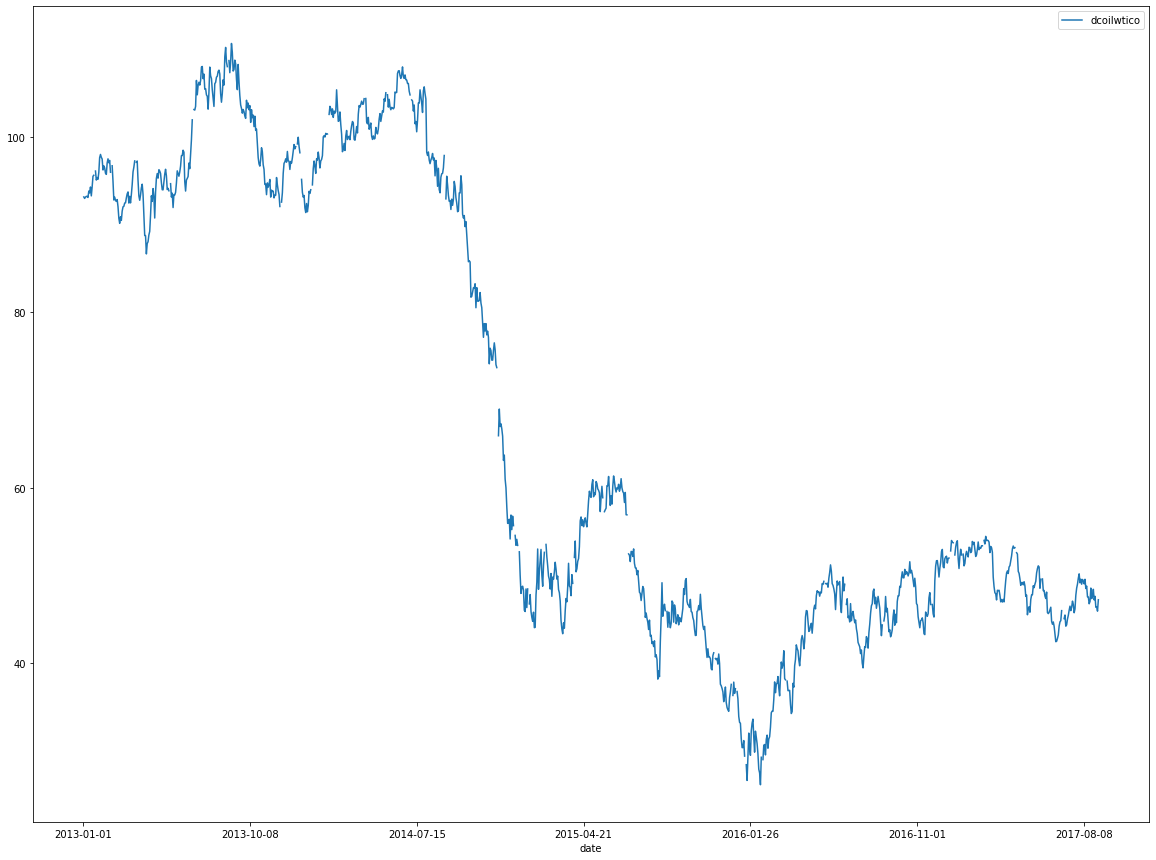

In [48]:
df_oil.plot(figsize=(20,15))

### Stores

In [49]:
df_stores = pd.read_csv('data/stores.csv')
df_stores.set_index('store_nbr', inplace=True)
df_stores.head()

city                           state type  cluster
store_nbr                                                             
1                  Quito                       Pichincha    D       13
2                  Quito                       Pichincha    D       13
3                  Quito                       Pichincha    D        8
4                  Quito                       Pichincha    D        9
5          Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [50]:
df_train = df_train.join(df_stores, on='store_nbr')
# df_train.head()

In [51]:
df_train.dtypes

id              object
store_nbr       object
family          object
sales           object
onpromotion     object
family_cat       int64
city            object
state           object
type            object
cluster        float64
dtype: object

some clusters are more predominant than others

In [52]:
df_train.groupby('cluster').sum().sort_values(by='sales').plot.pie(y='sales', figsize=(15,15), xlabel='cluster')


KeyError: 'sales'

### Holidays Events

In [20]:
df_holidays = pd.read_csv('data/holidays_events.csv')

In [21]:
df_holidays

date        type    locale locale_name  \
0    2012-03-02     Holiday     Local       Manta   
1    2012-04-01     Holiday  Regional    Cotopaxi   
2    2012-04-12     Holiday     Local      Cuenca   
3    2012-04-14     Holiday     Local    Libertad   
4    2012-04-21     Holiday     Local    Riobamba   
..          ...         ...       ...         ...   
345  2017-12-22  Additional  National     Ecuador   
346  2017-12-23  Additional  National     Ecuador   
347  2017-12-24  Additional  National     Ecuador   
348  2017-12-25     Holiday  National     Ecuador   
349  2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
345                      Navidad-3        False  
346                      Navidad-2        False  
347                      Navidad-1        False  
348                        Navidad        False  
349                      Navidad+1        False  

[350 rows x 6 columns]

In [22]:
df_train_sum = df_train['sales'].groupby(by='date').sum()
df_train_sum.head()

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
Name: sales, dtype: float64

<AxesSubplot:xlabel='date'>

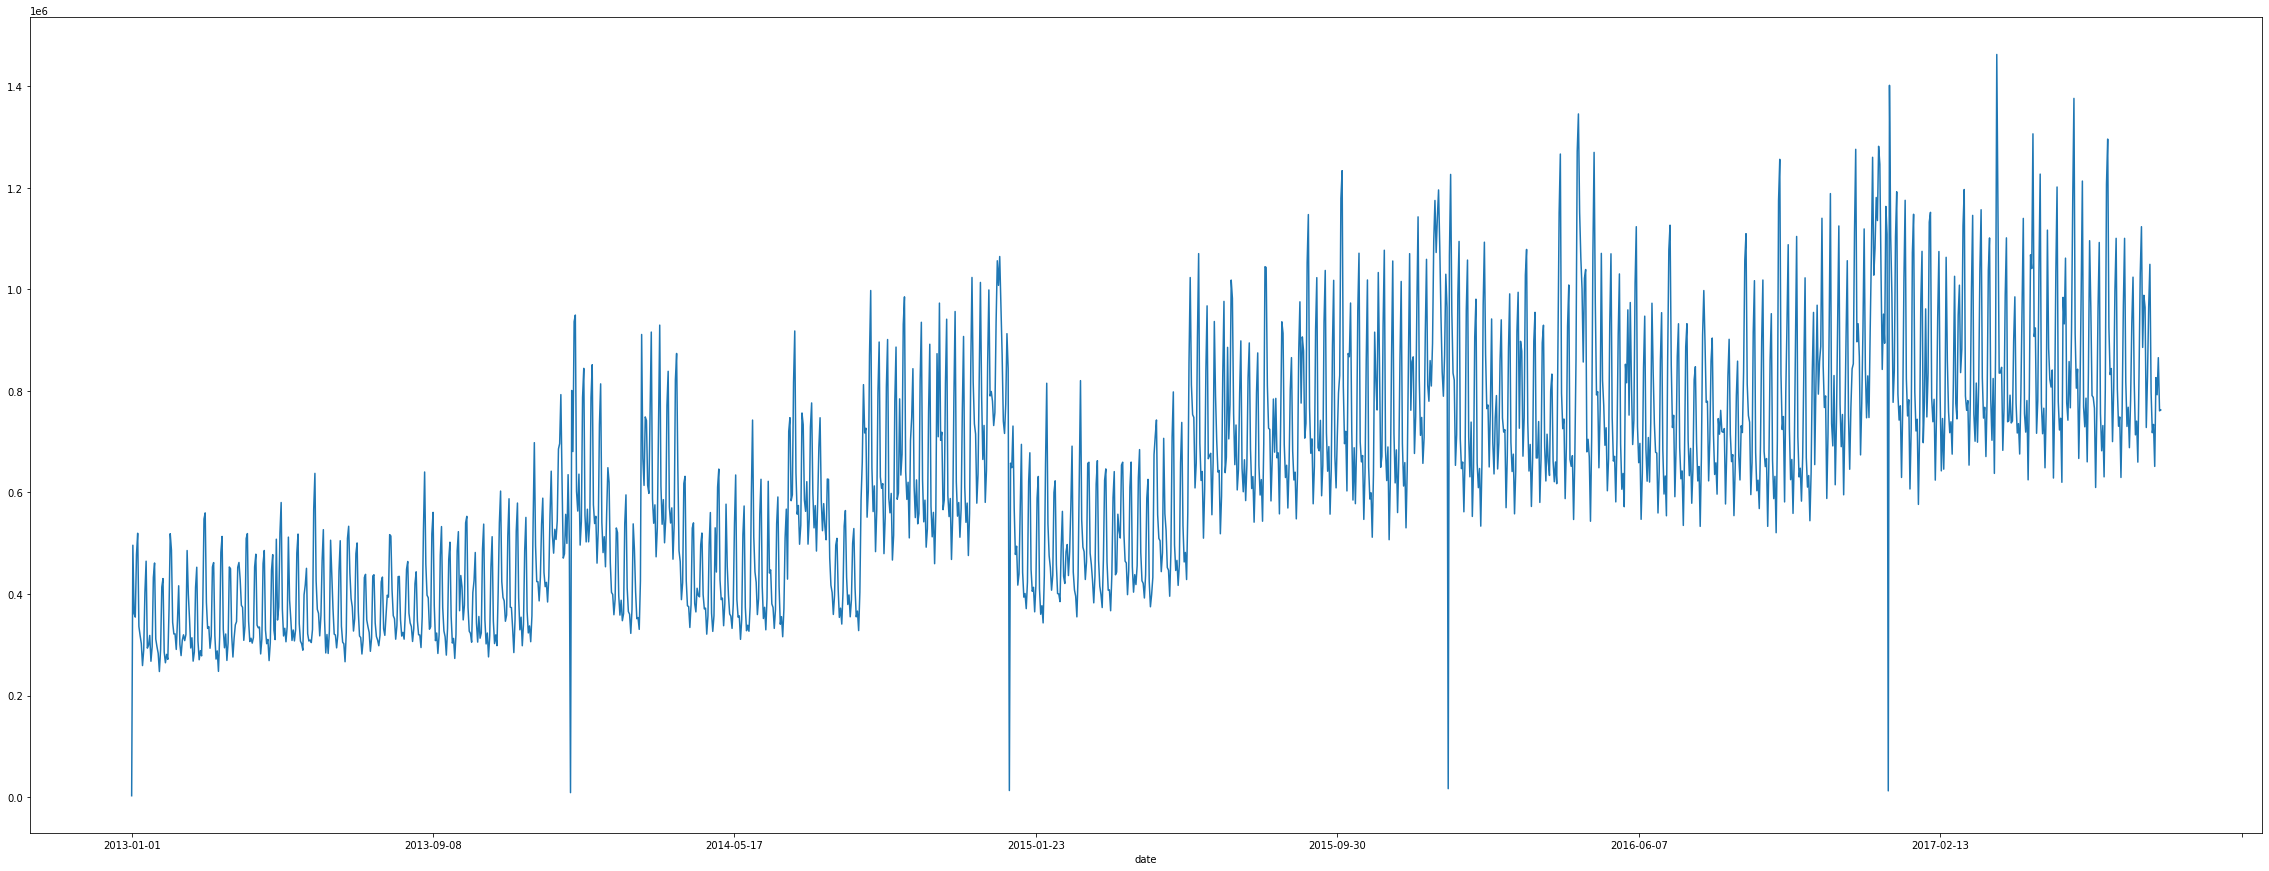

In [23]:
df_train['sales'].groupby(by='date').sum().plot(figsize=(40,15))

<AxesSubplot:xlabel='date'>

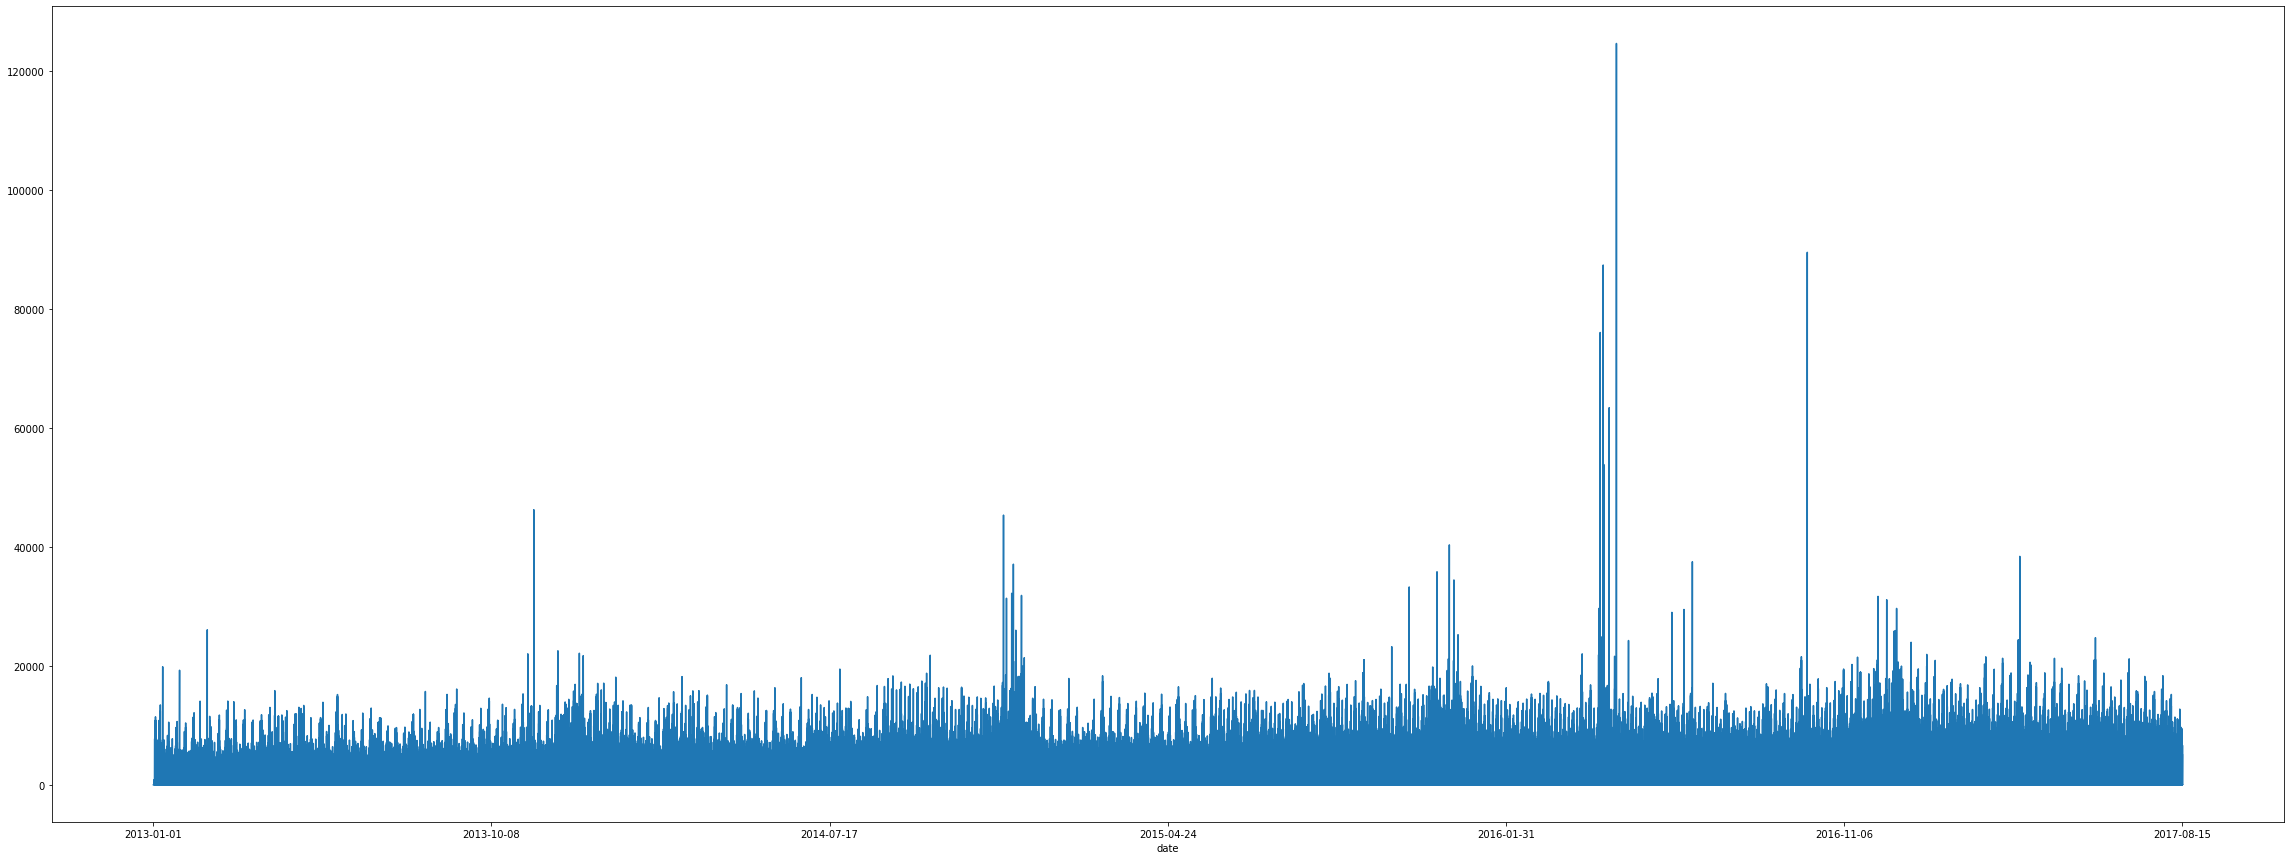

In [24]:
df_train['sales'].plot(figsize=(40,15))

In [25]:
df_train.shape

(3000888, 10)

due to the earthquake on April 2016, there are exceptional sales, so we can remove these points
let's consider a maximum of 5000

In [26]:
df_train = df_train[df_train['sales'] < 6000.0]

In [27]:
df_train.shape

(2975693, 10)

<AxesSubplot:xlabel='date'>

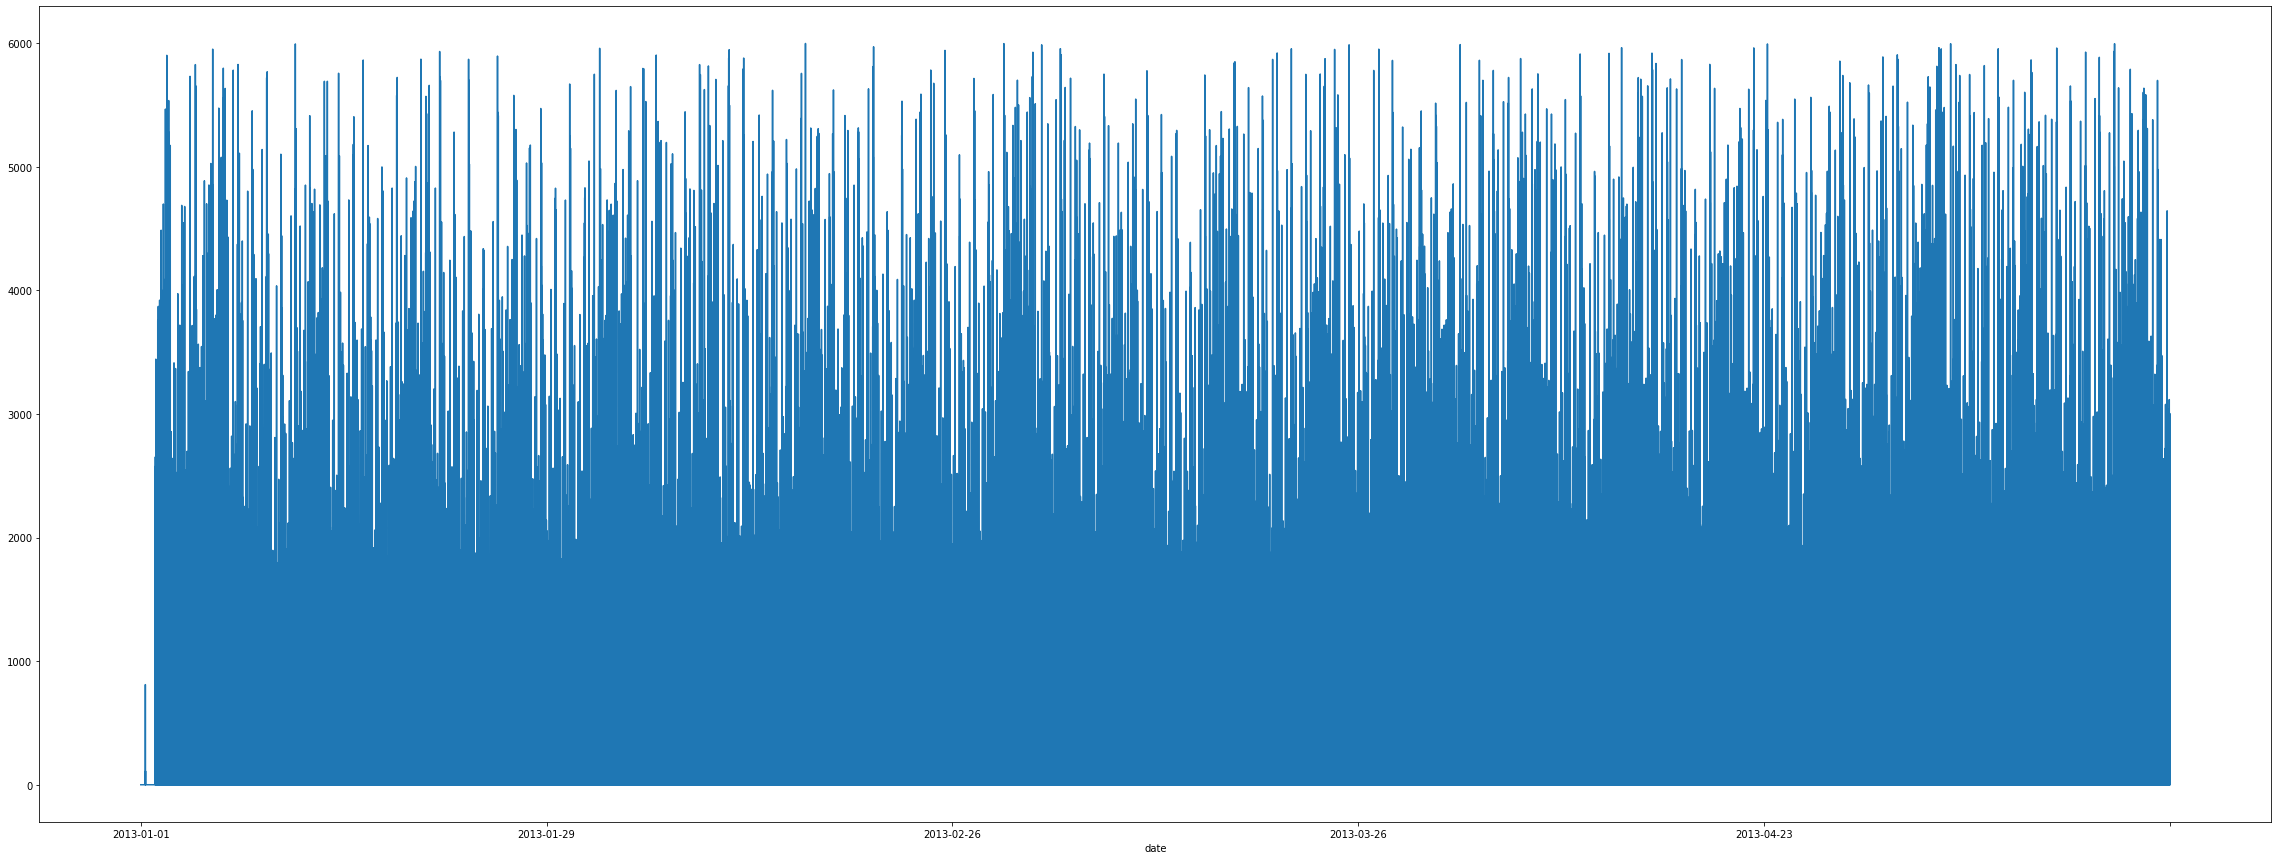

In [28]:
df_train['sales'][:250000].plot(figsize=(40,15))

### Family


In [53]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train['family_label'] = le.fit_transform(df_train.family)
df_test['family_label'] = le.transform(df_test.family)


In [54]:
df_train.tail()
df_train.shape
df_test.tail()
df_test.shape

(28512, 6)

In [55]:
n_predictions = df_test.shape[0]

In [56]:
df_train.groupby(['date','store_nbr', 'onpromotion', 'family_label']).count()

id  family  sales  family_cat  \
date       store_nbr onpromotion family_label                                  
2013-01-01 1         0           0              1       1      1           1   
                                 1              1       1      1           1   
                                 2              1       1      1           1   
                                 3              1       1      1           1   
                                 4              1       1      1           1   
...                                            ..     ...    ...         ...   
2017-08-15 54        10          8              1       1      1           1   
                     22          7              1       1      1           1   
                     23          3              1       1      1           1   
                     44          12             1       1      1           1   
                     76          30             1       1      1           1   

                                               city  state  type  cluster  
date       store_nbr onpromotion family_label                              
2013-01-01 1         0           0                1      1     1        1  
                                 1                1      1     1        1  
                                 2                1      1     1        1  
                                 3                1      1     1        1  
                                 4                1      1     1        1  
...                                             ...    ...   ...      ...  
2017-08-15 54        10          8                1      1     1        1  
                     22          7                1      1     1        1  
                     23          3                1      1     1        1  
                     44          12               1      1     1        1  
                     76          30               1      1     1        1  

[3008016 rows x 8 columns]

## Automotive Category

In [57]:
df_automotive = df_train[(df_train['family'] == 'AUTOMOTIVE') & (df_train['store_nbr'] == 1)]
df_automotive = df_automotive[['sales']]
df_automotive.shape
df_automotive

sales
date            
2013-01-01   0.0
2013-01-02   2.0
2013-01-03   3.0
2013-01-04   3.0
2013-01-05   5.0
...          ...
2017-08-15   4.0
2013-12-25     0
2014-12-25     0
2015-12-25     0
2016-12-25     0

[1688 rows x 1 columns]

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sc = StandardScaler()
mm = MinMaxScaler()
df_automotive['sales'] = mm.fit_transform(df_automotive[['sales']])

<AxesSubplot:xlabel='date'>

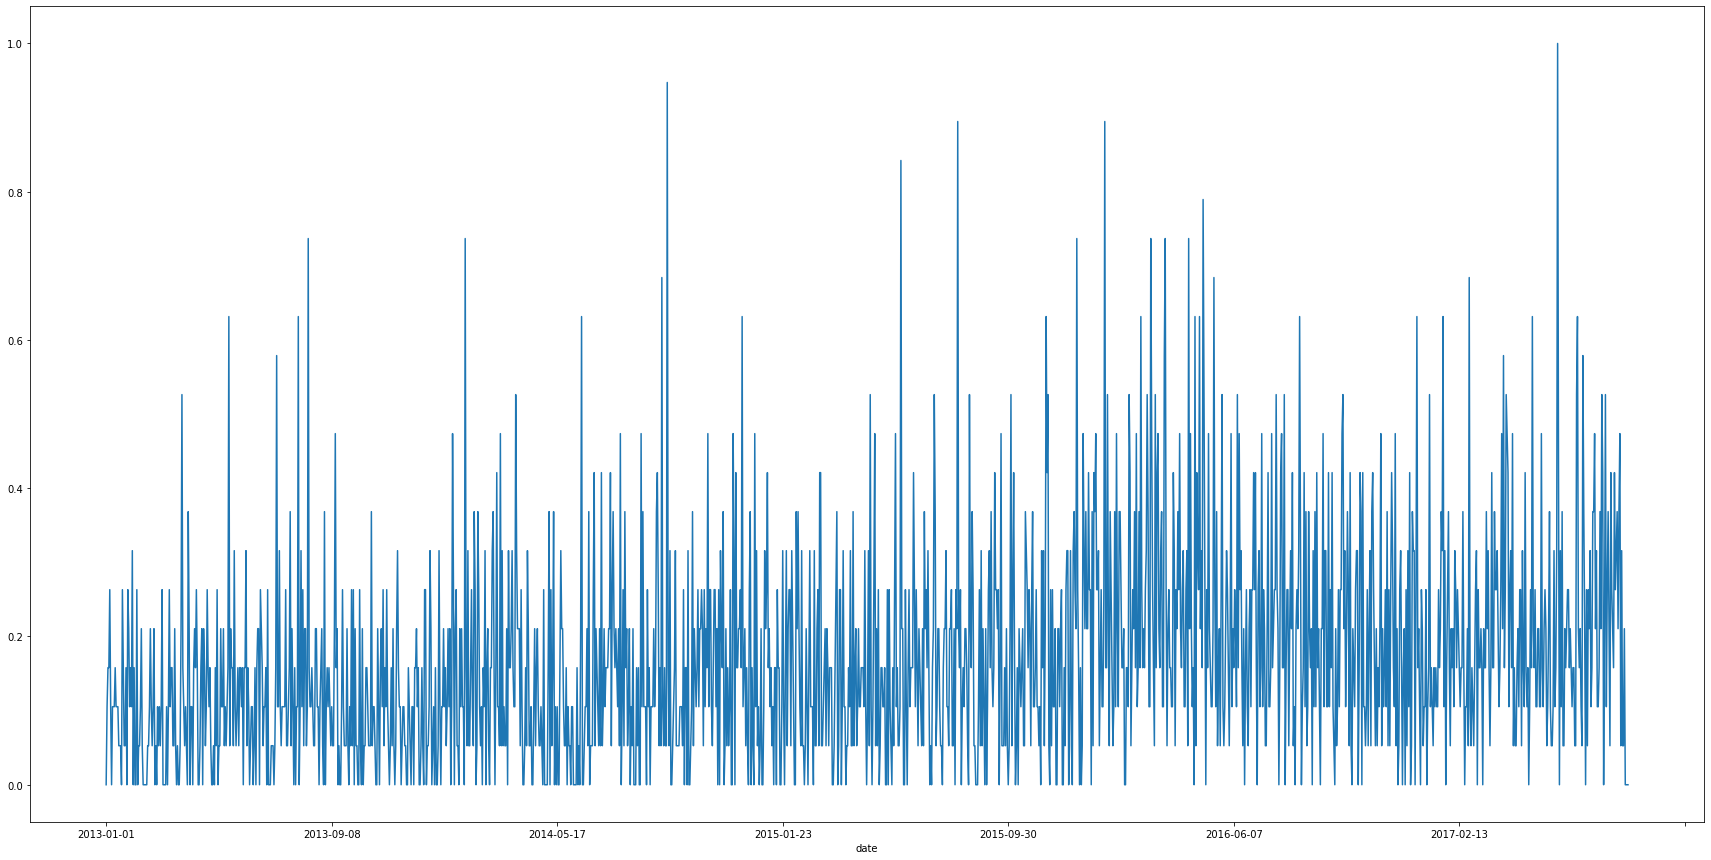

In [59]:
df_automotive['sales'].plot(figsize=(30,15))

In [60]:
df_test_automotive = df_test[(df_test['family'] == 'AUTOMOTIVE') & (df_test['store_nbr'] == 1)]
df_test_automotive.set_index('date', inplace=True)
df_test_automotive

id  store_nbr      family  onpromotion  family_label
date                                                                 
2017-08-16  3000888          1  AUTOMOTIVE            0             0
2017-08-17  3002670          1  AUTOMOTIVE            0             0
2017-08-18  3004452          1  AUTOMOTIVE            0             0
2017-08-19  3006234          1  AUTOMOTIVE            0             0
2017-08-20  3008016          1  AUTOMOTIVE            0             0
2017-08-21  3009798          1  AUTOMOTIVE            0             0
2017-08-22  3011580          1  AUTOMOTIVE            0             0
2017-08-23  3013362          1  AUTOMOTIVE            0             0
2017-08-24  3015144          1  AUTOMOTIVE            0             0
2017-08-25  3016926          1  AUTOMOTIVE            0             0
2017-08-26  3018708          1  AUTOMOTIVE            0             0
2017-08-27  3020490          1  AUTOMOTIVE            0             0
2017-08-28  3022272          1  AUTOMOTIVE            0             0
2017-08-29  3024054          1  AUTOMOTIVE            0             0
2017-08-30  3025836          1  AUTOMOTIVE            0             0
2017-08-31  3027618          1  AUTOMOTIVE            0             0

In [61]:
predictions_dates = df_test_automotive.index
predictions_dates
len(predictions_dates)
predictions_dates[0]

'2017-08-16'

## GluonTS

In [14]:
from gluonts.dataset.common import ListDataset
from gluonts.model.lstnet import LSTNetEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.dataset.pandas import PandasDataset


from gluonts.mx import Trainer

freq = "D"
# start = pd.Period("2013-01-01", freq=freq)
# prediction_length = 200 # predict this many points
context_length = 2000 # train on this number of points

In [219]:
# todo : manage multiple sub series
def fillMissingindex2(df: pd.DataFrame, sub1, sub2):
    
    for item_id, gdf in df.groupby(sub1).groupby(sub2):
        idx = pd.date_range(gdf.index.min(), gdf.index.max(), freq="1D")
        

    df_temp = df.groupby(sub1).groupby(sub2)
    # idx = pd.date_range('2013-01-01', '2017-08-15')
    idx = pd.date_range(df_temp.index.min(), df_temp.index.max())
    df_temp.index = pd.DatetimeIndex(df_temp.index)
    df_temp = df_temp.reindex(idx, fill_value=0)
    return df

def fillMissingindex(df):
    # idx = pd.date_range('2013-01-01', '2017-08-15')
    idx = pd.date_range(df.index.min(), df.index.max())
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=0)
    return df

In [137]:

prediction_length=5000

df = df_train [['store_nbr', 'family', 'sales']]
df = df [df['store_nbr'] == 1]
df = df.astype({'store_nbr': 'string', 'family':'string', 'sales': 'int',})
df.dtypes

store_nbr    string
family       string
sales         int64
dtype: object

In [138]:

ds = PandasDataset.from_long_dataframe(df, freq='d', target='sales', item_id=['family'])
ds_train = PandasDataset.from_long_dataframe(df[:-prediction_length], freq='d', target='sales', item_id=['family'])
ds_test = PandasDataset.from_long_dataframe(df.tail(prediction_length), freq='d', target='sales', item_id=['family'])


In [139]:
ds_train

PandasDataset(dataframes={'AUTOMOTIVE':            store_nbr      family  sales
date                                   
2013-01-01         1  AUTOMOTIVE      0
2013-01-02         1  AUTOMOTIVE      2
2013-01-03         1  AUTOMOTIVE      3
2013-01-04         1  AUTOMOTIVE      3
2013-01-05         1  AUTOMOTIVE      5
...              ...         ...    ...
2017-03-13         1  AUTOMOTIVE      3
2017-03-14         1  AUTOMOTIVE      3
2017-03-15         1  AUTOMOTIVE      7
2017-03-16         1  AUTOMOTIVE      4
2017-03-17         1  AUTOMOTIVE      6

[1537 rows x 3 columns], 'BABY CARE':            store_nbr     family  sales
date                                  
2013-01-01         1  BABY CARE      0
2013-01-02         1  BABY CARE      0
2013-01-03         1  BABY CARE      0
2013-01-04         1  BABY CARE      0
2013-01-05         1  BABY CARE      0
...              ...        ...    ...
2017-03-13         1  BABY CARE      0
2017-03-14         1  BABY CARE      0
2017-03-15 

In [140]:
ds_test 

PandasDataset(dataframes={'AUTOMOTIVE':            store_nbr      family  sales
date                                   
2017-03-18         1  AUTOMOTIVE      3
2017-03-19         1  AUTOMOTIVE      1
2017-03-20         1  AUTOMOTIVE      3
2017-03-21         1  AUTOMOTIVE      8
2017-03-22         1  AUTOMOTIVE      3
...              ...         ...    ...
2017-08-11         1  AUTOMOTIVE      1
2017-08-12         1  AUTOMOTIVE      6
2017-08-13         1  AUTOMOTIVE      1
2017-08-14         1  AUTOMOTIVE      1
2017-08-15         1  AUTOMOTIVE      4

[151 rows x 3 columns], 'BABY CARE':            store_nbr     family  sales
date                                  
2017-03-18         1  BABY CARE      0
2017-03-19         1  BABY CARE      0
2017-03-20         1  BABY CARE      0
2017-03-21         1  BABY CARE      0
2017-03-22         1  BABY CARE      0
...              ...        ...    ...
2017-08-11         1  BABY CARE      0
2017-08-12         1  BABY CARE      0
2017-08-13  

In [141]:
estimator = DeepAREstimator(
    freq=ds.freq, 
    prediction_length=200, 
    trainer=Trainer(
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=10,
        patience=2
        )
)


In [142]:
predictor = estimator.train(ds)


100%|██████████| 10/10 [00:04<00:00,  2.44it/s, epoch=5/5, avg_epoch_loss=4.18]


In [143]:
predictor.predict(ds)
predictor.predict(ds_test)

<generator object GluonPredictor.predict at 0x17bbd8040>

<generator object GluonPredictor.predict at 0x17a09b820>

In [144]:
# now make predictions, following dates provided in test set
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=ds_train,  # test dataset
    predictor=predictor,  # predictor
    num_samples=10,  # number of sample paths we want for evaluation
)


tss = list(ts_it)
forecasts = list(forecast_it)


In [146]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)
agg_metrics
item_metrics

Running evaluation: 33it [00:00, 105.43it/s]
/Users/vincentjuge/devel/vjuge/oc-iml/venv/lib/python3.9/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/Users/vincentjuge/devel/vjuge/oc-iml/venv/lib/python3.9/site-packages/gluonts/evaluation/_base.py:361: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/vincentjuge/devel/vjuge/oc-iml/venv/lib/python3.9/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error


{'MSE': 68794.88396425535,
 'abs_error': 615326.1726989746,
 'abs_target_sum': 2153751.0,
 'abs_target_mean': 326.32590909090914,
 'seasonal_error': 86.22333618428789,
 'MASE': inf,
 'MAPE': 2.1427959468481674,
 'sMAPE': 0.7779771244164668,
 'MSIS': inf,
 'QuantileLoss[0.1]': 244486.16067488797,
 'Coverage[0.1]': 0.10212121212121213,
 'QuantileLoss[0.5]': 615326.193379574,
 'Coverage[0.5]': 0.2589393939393939,
 'QuantileLoss[0.9]': 543108.415827021,
 'Coverage[0.9]': 0.561212121212121,
 'RMSE': 262.2877884390643,
 'NRMSE': 0.8037602321242446,
 'ND': 0.2856997734180853,
 'wQuantileLoss[0.1]': 0.11351644673636273,
 'wQuantileLoss[0.5]': 0.28569978302021637,
 'wQuantileLoss[0.9]': 0.2521686192261877,
 'mean_absolute_QuantileLoss': 467640.256627161,
 'mean_wQuantileLoss': 0.2171282829942556,
 'MAE_Coverage': 0.19398989898989907,
 'OWA': nan}

item_id            MSE      abs_error  abs_target_sum  \
0                   AUTOMOTIVE       9.479131     494.369659           737.0   
1                    BABY CARE    4733.209375   13478.819336             0.0   
2                       BEAUTY      13.062363     598.689758           714.0   
3                    BEVERAGES  474828.640000  118292.859375        435671.0   
4                        BOOKS    4686.397187   13472.398438           159.0   
5                 BREAD/BAKERY   10770.973750   15703.675781         76747.0   
6                  CELEBRATION     148.391045    1916.001709          3157.0   
7                     CLEANING   37553.070000   30544.783203        133263.0   
8                        DAIRY   30850.350000   27422.417969        147220.0   
9                         DELI    1621.050156    6179.912109         26145.0   
10                        EGGS    1383.489375    5263.757812         26421.0   
11                FROZEN FOODS   40793.782500   15517.514648         29514.0   
12                   GROCERY I  894656.560000  153439.265625        528225.0   
13                  GROCERY II     175.101406    1845.614258          3890.0   
14                    HARDWARE       5.563724     359.473236           382.0   
15          HOME AND KITCHEN I     402.535000    2895.611084          4261.0   
16         HOME AND KITCHEN II     220.973242    2538.738770          5134.0   
17             HOME APPLIANCES       0.338670      50.440918            40.0   
18                   HOME CARE    2267.531562    7801.903320         34538.0   
19                  LADIESWEAR      87.480830    1566.837524          2856.0   
20             LAWN AND GARDEN     180.643535    1832.923462          2571.0   
21                    LINGERIE      31.046130     781.815979           931.0   
22            LIQUOR,WINE,BEER    4102.867500    8303.361328         21760.0   
23                   MAGAZINES      49.479961    1202.001465          1446.0   
24                       MEATS   27318.225000   21360.566406         62021.0   
25               PERSONAL CARE    4673.658750    7728.162109         29970.0   
26                PET SUPPLIES      27.037163     893.399658          1187.0   
27     PLAYERS AND ELECTRONICS      45.746157    1146.162720          1941.0   
28                     POULTRY    9250.075000   13807.564453         60817.0   
29              PREPARED FOODS     946.963281    4694.379883         17974.0   
30                     PRODUCE  718253.920000  132214.937500        488721.0   
31  SCHOOL AND OFFICE SUPPLIES       0.790606      90.151581            80.0   
32                     SEAFOOD     142.738418    1887.661621          5258.0   

    abs_target_mean  seasonal_error      MASE       MAPE     sMAPE         ND  \
0             3.685        2.692365  0.918095   0.605065  0.920443   0.670786   
1             0.000        0.000000       inf        NaN  2.000000        inf   
2             3.570        1.757485  1.703257   0.794988  1.410620   0.838501   
3          2178.355      441.998502  1.338159   0.268634  0.303289   0.271519   
4             0.795        0.000000       inf  52.940659  2.000000  84.732063   
5           383.735      106.778277  0.735340   0.273887  0.243122   0.204616   
6            15.785        6.335581  1.512096   0.699924  0.782775   0.606906   
7           666.315      222.416479  0.686657   0.273566  0.266359   0.229207   
8           736.100      189.023970  0.725369   0.231037  0.215790   0.186268   
9           130.725       43.486142  0.710561   0.278742  0.267713   0.236371   
10          132.105       48.107865  0.547079   0.230976  0.219645   0.199226   
11          147.570       58.325094  1.330261   0.356918  0.430611   0.525768   
12         2641.125      676.997004  1.133234   0.283948  0.324051   0.290481   
13           19.450       13.412734  0.688008   0.487863  0.513513   0.474451   
14            1.910        1.602996  1.121254   0.864270  1.638769   0.941029   
15    

In [83]:
# DeepAREstimator

train_ds = ListDataset(
    [{
        "start": df_automotive.index[0],
        "target": df_automotive.sales[:-prediction_length]
    }],
    freq=freq
)

test_ds = ListDataset(
    [{
        "start": df_automotive.index[0],
        "target": df_automotive.sales[:]
    }],
    freq=freq
)


In [86]:

estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq='D',
    context_length=context_length,
    trainer=Trainer(
        ctx='cpu',
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=10,
        patience=2
    )
)
predictor = estimator.train(training_data=train_ds)


100%|██████████| 10/10 [00:19<00:00,  1.90s/it, epoch=5/5, avg_epoch_loss=-.774]


GluonTS multivariate :

<https://github.com/awslabs/gluonts/issues/494>

<https://github.com/awslabs/gluonts/issues/517>

<https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html>



In [79]:
from gluonts.evaluation import Evaluator
from gluonts.evaluation import make_evaluation_predictions
import matplotlib.pyplot as plt
import json
import numpy as np

def make_predictions(_predictor, ds, num_samples=100):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=ds,  # test dataset
        predictor=_predictor,  # predictor
        num_samples=num_samples,  # number of sample paths we want for evaluation
    )
    return list(forecast_it), list(ts_it)

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = context_length + prediction_length
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [ f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(40, 20))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="cadetblue")
    plt.axvline(forecast_entry.start_date, color="g", lw=1) #end of train dataset
    plt.grid(which="major")
    plt.legend(legend, loc="upper left")
    plt.show()

def gluonts_metrics(tss, forecasts):
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(tss, forecasts)

    print(json.dumps(agg_metrics, indent=4))

def train_and_predict(dataset, estimator):
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor
    )
    evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
    agg_metrics, item_metrics = evaluator(ts_it, forecast_it, num_series=len(dataset))
    return agg_metrics["RMSE"]

In [80]:

(forecasts, tss) = make_predictions(predictor, test_ds, prediction_length)
forecasts
tss
plot_prob_forecasts(tss[0], forecasts[0])
gluonts_metrics(tss, forecasts)

NameError: name 'test_ds' is not defined

In [88]:
tss[0]
df_automotive['predicted'] = mm.inverse_transform(tss[0])
df_automotive

0
2013-01-01  0.000000
2013-01-02  0.105263
2013-01-03  0.157895
2013-01-04  0.157895
2013-01-05  0.263158
...              ...
2017-08-07  0.052632
2017-08-08  0.315789
2017-08-09  0.052632
2017-08-10  0.052632
2017-08-11  0.210526

[1684 rows x 1 columns]

sales  predicted
date                           
2013-01-01  0.000000        0.0
2013-01-02  0.105263        2.0
2013-01-03  0.157895        3.0
2013-01-04  0.157895        3.0
2013-01-05  0.263158        5.0
...              ...        ...
2017-08-11  0.052632        1.0
2017-08-12  0.315789        6.0
2017-08-13  0.052632        1.0
2017-08-14  0.052632        1.0
2017-08-15  0.210526        4.0

[1684 rows x 2 columns]

### Predictions

## Prophet

In [65]:
from prophet import Prophet

m = Prophet()
df_automotive['ds'] = df_automotive.index
df_automotive['y'] = df_automotive['sales']

df_automotive

/tmp/ipykernel_2000820/2615168408.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['ds'] = df_automotive.index
/tmp/ipykernel_2000820/2615168408.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['y'] = df_automotive['sales']


id  store_nbr      family     sales  onpromotion  family_cat  \
date                                                                            
2013-01-01        0          1  AUTOMOTIVE  0.000000            0           0   
2013-01-02     1782          1  AUTOMOTIVE  0.105263            0           0   
2013-01-03     3564          1  AUTOMOTIVE  0.157895            0           0   
2013-01-04     5346          1  AUTOMOTIVE  0.157895            0           0   
2013-01-05     7128          1  AUTOMOTIVE  0.263158            0           0   
...             ...        ...         ...       ...          ...         ...   
2017-08-11  2991978          1  AUTOMOTIVE  0.052632            0           0   
2017-08-12  2993760          1  AUTOMOTIVE  0.315789            0           0   
2017-08-13  2995542          1  AUTOMOTIVE  0.052632            0           0   
2017-08-14  2997324          1  AUTOMOTIVE  0.052632            0           0   
2017-08-15  2999106          1  AUTOMOTIVE  0.210526            0           0   

             city      state type  cluster  family_label          ds         y  
date                                                                            
2013-01-01  Quito  Pichincha    D       13             0  2013-01-01  0.000000  
2013-01-02  Quito  Pichincha    D       13             0  2013-01-02  0.105263  
2013-01-03  Quito  Pichincha    D       13             0  2013-01-03  0.157895  
2013-01-04  Quito  Pichincha    D       13             0  2013-01-04  0.157895  
2013-01-05  Quito  Pichincha    D       13             0  2013-01-05  0.263158  
...           ...        ...  ...      ...           ...         ...       ...  
2017-08-11  Quito  Pichincha    D       13             0  2017-08-11  0.052632  
2017-08-12  Quito  Pichincha    D       13             0  2017-08-12  0.315789  
2017-08-13  Quito  Pichincha    D       13             0  2017-08-13  0.052632  
2017-08-14  Quito  Pichincha    D       13             0  2017-08-14  0.052632  
2017-08-15  Quito  Pichincha    D       13             0  2017-08-15  0.210526  

[1684 rows x 13 columns]

In [66]:
m.fit(df_automotive[:100000])

22:08:05 - cmdstanpy - INFO - Chain [1] start processing
22:08:05 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
2044 2018-08-11
2045 2018-08-12
2046 2018-08-13
2047 2018-08-14
2048 2018-08-15

In [68]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds      yhat  yhat_lower  yhat_upper
2044 2018-08-11  0.264272    0.084280    0.435797
2045 2018-08-12  0.140258   -0.025872    0.293706
2046 2018-08-13  0.236422    0.068713    0.402568
2047 2018-08-14  0.263924    0.085430    0.427626
2048 2018-08-15  0.244148    0.076769    0.419871

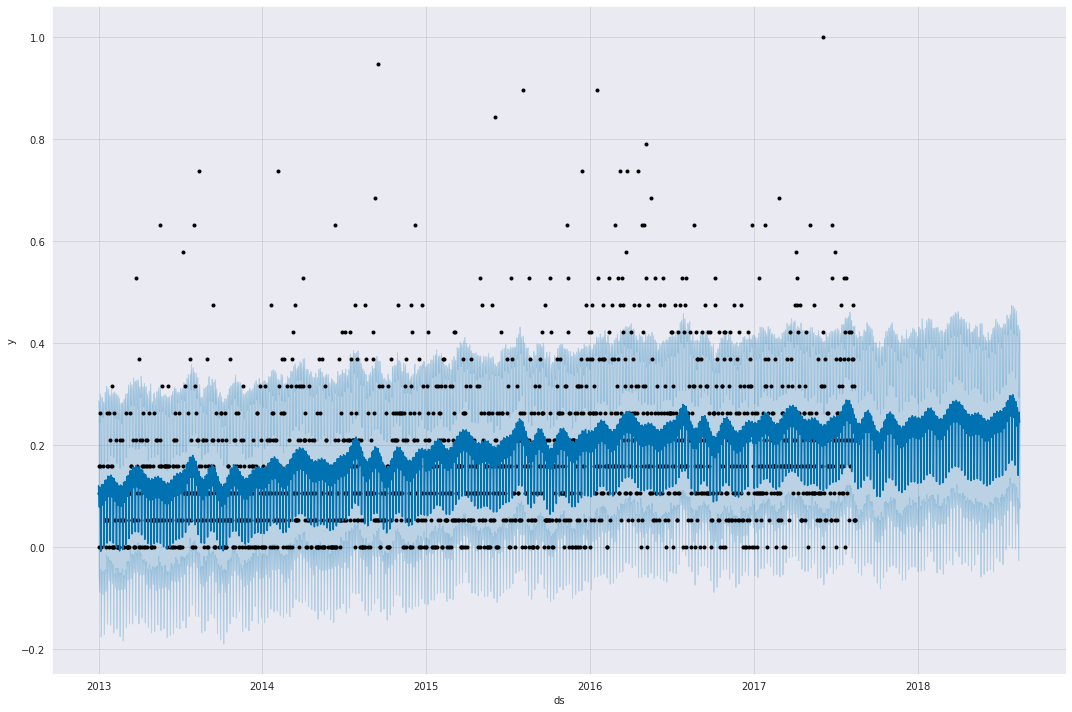

In [72]:
fig1 = m.plot(forecast, figsize=(15,10))


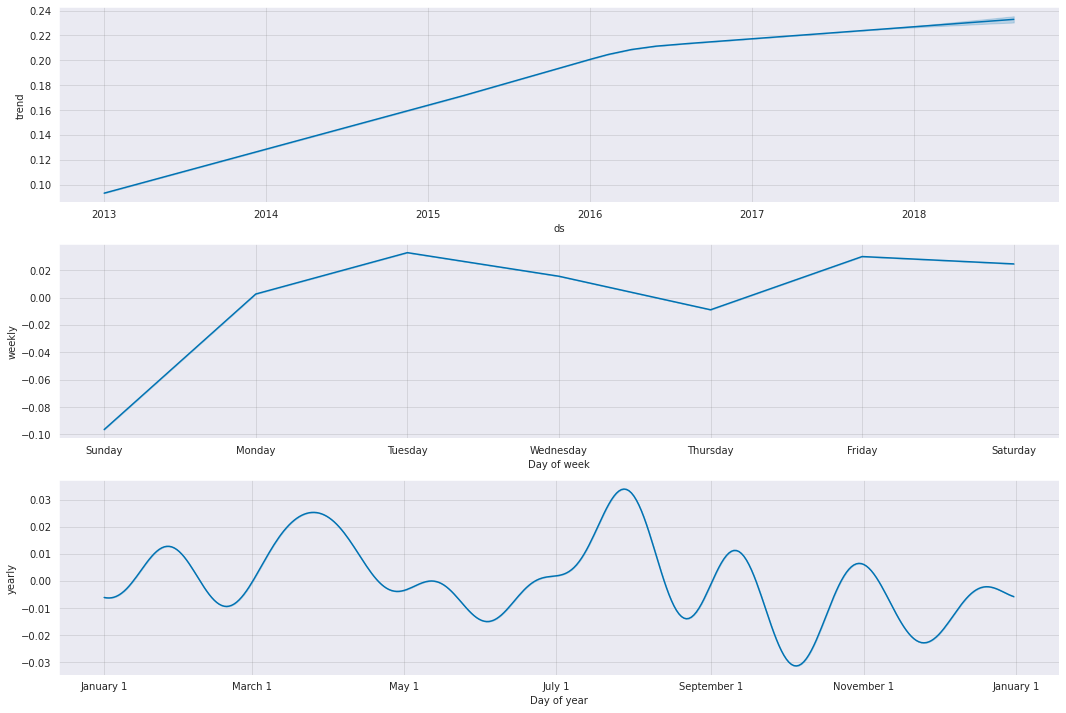

In [73]:
fig2 = m.plot_components(forecast, figsize=(15,10))


In [75]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [76]:
plot_components_plotly(m, forecast)


/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/plotly/io/_json.py:469: UserWarning:

Discarding nonzero nanoseconds in conversion

